In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 13 17:11:20 2020
Download a WhatsApp group chat .txt file and this can analyze it.
Creates word cloud, high level statistics, and then uses Kmeans clustering to
interpret conversation themes.
Example uses boulder climbers group chat
@author: patno_000
"""
"""
this first cell is exploration, the next cell I automate each step in this cell 
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import seaborn as sns

fp = 'WhatsApp Chat with Boulder Climbing Partners (2).txt'
file = open(fp,'r', encoding='UTF-8')
txt_data = file.read()
file.close()
len(txt_data)
"""
alternatively,
with open(fp,'r', encoding='UTF-8') as file:
    txt_data = file.read()
"""
### Really bad way to find update time
ltu = 18
spots = {}
for ltu in range(16, 19):
    for i in range(len(txt_data) - ltu):
        test = txt_data[i:i+ltu]
        if re.search('\A\n.+..:.. -$',test):
            spots.update({i : test})
spots

spots_s = dict(sorted(spots.items()))
len(spots)
max(spots)
# try different objects
type(spots.items())
type(spots.keys())
type(spots.values())

starts = list(spots_s.keys())
starts[-10:]
starts[:10]
txt_data[:starts[2]]
messages = []
len(list(spots.values())[30])
spots_ss = sorted(spots.items())
type(spots_ss)
spots_ss[:10]

len(spots_ss)
len(spots_s)
type(spots_s)
type(spots_ss)

starts[0]
ends = []
for i in range(len(starts)-1):
    ends.append(starts[i+1])

ends.append(len(txt_data))
#verify same length
print(len(ends))
print(len(starts))

print(starts[:10], ends[:10])
#split data by start/end
data = [txt_data[i:j] for i,j in zip(starts, ends)]
data[:10]
#find where date starts
comma = [x.find(",") for x in data]
date = pd.Series([data[x][:comma[x]] for x in range(len(data))], name="raw_dt")
#find where time ends
dash = [x.find("-") for x in data]
#import timeit
#%timeit max(set(dash)) # ~2 times faster
#%timeit max(dash)
data[-10:]
time1 = [data[x][comma[x]+2:dash[x]-1] for x in range(len(data))]
time = pd.Series(time1, name="time")
colon = [x.find(":") for x in data[-10:]]

max(set(np.array(comma) + np.array(dash)))
min(set(np.array(comma) + np.array(dash)))
data[-1][dash[-1]:len(data[-1])].find(":")

colon_plus = [data[i][dash[i]:len(data[i])].find(":") for i in range(len(data))]

notif_type = pd.Series(["Join/Leave" if colon_plus[i] < 0 else "Message" for i in range(len(colon_plus))], name="notif_type")
##### NEED TO MAKE THIS CHANGE FOR JOIN/LEAVE
# find phone number, two types appear in data based on join/leave or message
phone1 = [data[i][dash[i]+2:dash[i]+colon_plus[i]] for i in range(len(data))]
left = [x.find("left") for x in data]
joined = [x.find("joined") for x in data]
max(set(phone1), key=phone1.count)
phone1.count('')
notif_type.groupby(notif_type).agg('count')
notif_type[i]
phone2 = {i : data[i][dash[i]+2:max([left[i],joined[i]])-1] for i in range(len(data)) if notif_type[i] != 'Message'}
max([left[i],joined[i]])
len(phone2)

phone3 = []
for i in range(len(phone1)):
    if phone1[i] != '':
        phone3.append(phone1[i])
    else:
        phone3.append(phone2[i])

phone = pd.Series(phone3, name = "phone")

msg = [data[i][max(colon_plus[i]+len(phone1[i]),dash[i] +len(phone3[i])+3):] for i in range(len(data))]
message = pd.Series(msg, name="Message")
#pull raw columns together into a df
df = pd.concat([date, time, notif_type, phone, message], axis = 1)

print(df.tail())
df.columns

#check if start always starts the same
set([x[0:1] for x in list(df.raw_dt)])

df['date'] = df['raw_dt']
df = df.drop('date', axis=1)
#get dates into a list
dts = [*df['raw_dt']]
#get rid of \n
dt_clean = [datetime.strptime(x[1:], '%m/%d/%y') for x in dts]

df['date'] = dt_clean
df.dtypes

df['time'].head()

times =[datetime.strptime(x, '%H:%M').time() for x in df['time']]
df['time_act'] = times



3190
3190
[156, 221, 280, 353, 426, 499, 585, 622, 690, 756] [221, 280, 353, 426, 499, 585, 622, 690, 756, 856]
         raw_dt   time  notif_type              phone  \
3185  \n11/6/20  21:22     Message  +1 (858) 431-6492   
3186  \n11/7/20  07:35     Message   +49 1516 8191830   
3187  \n11/7/20  08:35  Join/Leave  +1 (203) 253-8484   
3188  \n11/7/20  10:06  Join/Leave   +34 667 26 68 65   
3189  \n11/7/20  10:23     Message  +1 (720) 546-9339   

                                                Message  
3185                                                 +1  
3186   One last try. Someone for CCC wall of the 90'...  
3187                                               left  
3188                                               left  
3189                                               🤟🏼\n  


In [2]:
""" 
create object for loading whatsapp message data
NOTE: this automates the above code so you can use with other group chats
"""

class WhatsAppDF():
    # only input is a filepath of .txt file, will be created to DF
    def __init__(self, filepath):
        self.filepath = filepath
        with open(filepath,'r', encoding='UTF-8') as file:
            self.data_raw = file.read()
    
        self.spots = {}
        for ltu in range(16, 19):
            for i in range(len(self.data_raw) - ltu):
                test = self.data_raw[i:i+ltu]
                if re.search('\A\n.+..:.. -$',test):
                    self.spots.update({i : test})
    
        #all attributes available but not really needed
        self.spots_s = dict(sorted(self.spots.items()))
        self.starts = list(self.spots_s.keys())
        self.spots_ss = sorted(self.spots.items())
        self.starts = list(self.spots_s.keys())
        
        self.ends = []
        for i in range(len(starts)-1):
            self.ends.append(starts[i+1])
        
        self.ends.append(len(self.data_raw))
    
    
        self.data1 = [self.data_raw[i:j] for i,j in zip(self.starts, self.ends)]
        #find where date starts
        self.comma = [x.find(",") for x in self.data1]
        self.date = pd.Series([self.data1[x][:self.comma[x]] for x in range(len(self.data1))], name="raw_dt")
        #find where time ends
        self.dash = [x.find("-") for x in self.data1]
        #import timeit
        #%timeit max(set(dash)) # ~2 times faster
        #%timeit max(dash)
        self.time1 = [self.data1[x][self.comma[x]+2:self.dash[x]-1] for x in range(len(self.data1))]
        self.time = pd.Series(self.time1, name="time")
        self.colon = [x.find(":") for x in self.data1[-10:]]
        
        
        self.colon_plus = [self.data1[i][self.dash[i]:len(self.data1[i])].find(":") for i in range(len(self.data1))]
        
        self.notif_type = pd.Series(["Join/Leave" if self.colon_plus[i] < 0 else "Message" for i in range(len(self.colon_plus))], name="notif_type")
        # find phone number, two types appear in data based on join/leave or message
        self.phone1 = [self.data1[i][self.dash[i]+2:self.dash[i]+self.colon_plus[i]] for i in range(len(self.data1))]
        self.left = [x.find("left") for x in self.data1]
        self.joined = [x.find("joined") for x in self.data1]
        self.phone2 = {i : self.data1[i][self.dash[i]+2:max([self.left[i],self.joined[i]])-1] for i in range(len(self.data1)) if self.notif_type[i] != 'Message'}
        
        self.phone3 = []
        for i in range(len(self.phone1)):
            if self.phone1[i] != '':
                self.phone3.append(self.phone1[i])
            else:
                self.phone3.append(self.phone2[i])
        
        self.phone = pd.Series(self.phone3, name = "phone")
        
        self.msg = [self.data1[i][max(self.colon_plus[i]+len(self.phone1[i]),self.dash[i] +len(self.phone3[i])+3):] for i in range(len(self.data1))]
        self.message = pd.Series(self.msg, name="Message")
        #pull raw columns together into a df
    
    def create_df(self):
        self.df = pd.concat([self.date, self.time, self.notif_type, self.phone, self.message], axis = 1)

        self.df['date'] = self.df['raw_dt']
        #get dates into a list
        self.dts = [*self.df['raw_dt']]
        #get rid of \n
        self.dt_clean = [datetime.strptime(x[1:], '%m/%d/%y') for x in self.dts]
        
        self.df['date'] = self.dt_clean
        
        self.times =[datetime.strptime(x, '%H:%M').time() for x in self.df['time']]
        self.df['time_act'] = self.times
        return self.df
    

In [3]:
    
X = WhatsAppDF(fp)
df = X.create_df()

df.groupby(by='phone')['Message'].count()
#easier to see than in gui
df.to_csv('final_'+'.csv')

In [4]:
#problem phone number characters
probs = ['changed', 'was', 'added', 'created', 'deleted']
df.shape
for i in range(len(df)):
    test = df.loc[i]['phone']
    status = False
    for val in probs:
        status = status or val in test
 
    if status == True:
        df = df.drop(i)

df.shape
df['phone'].head()
df.to_csv('final_1'+'.csv')

C:\Users\patno_000\Anaconda3.1\envs\tf_testing\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='TOD', ylabel='phone'>

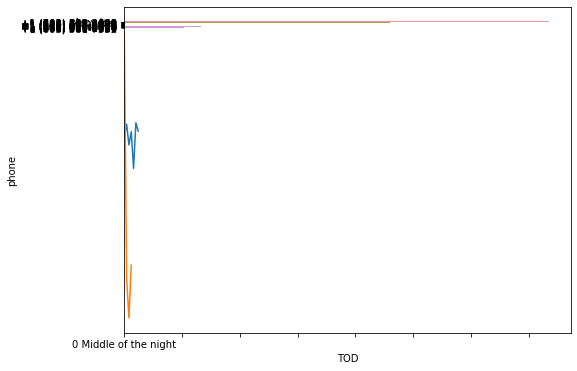

In [11]:
"""clean up the data"""
nbrs = df[df['notif_type']=='Message'].groupby(by='phone')['Message'].agg('count')
c1 = pd.Series(nbrs.index, name = 'phone')
c2 = pd.Series(nbrs.values, name  = 'count')
nbrs2 = pd.concat([c1,c2], axis = 1).sort_values(by=['count'], ascending = False)
plt.figure(figsize=(8,6))
sns.barplot(x='count', y='phone', orient='h', data=nbrs2[:25])


df['day'] = df['date'].dt.dayofweek
df.groupby(by='day')['Message'].count().plot()

TOD = []
TODind = []
for i in range(df.shape[0]):
    test = df.iloc[i]['time_act']
    if test.hour < 6:
        x = '0 Middle of the night'
        y = 0
    elif test.hour < 12:
        x = '1 Morning'
        y = 1
    elif test.hour < 18:
        x = '2 Afternoon'
        y = 2
    else:
        x = '3 Night'
        y = 3
    TOD.append(x)
    TODind.append(y)

df['TOD'] = TOD    
df['TODind'] = TODind


C:\Users\patno_000\Anaconda3.1\envs\tf_testing\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='TOD'>

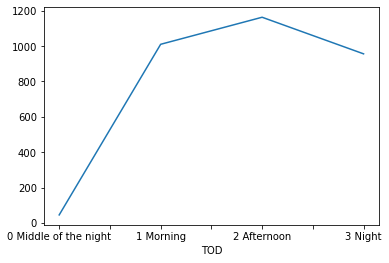

In [12]:
df.groupby(by = 'TOD')['Message'].count().plot()

In [13]:
x = ' '.join(df[df['notif_type']=='Message']['Message'])
len(x)
x = x.replace('\n', ' ')
len(x)
wrds = x.split(' ')
wrds = [x for x in wrds if x != '']
len(wrds)
wrds
max(set(wrds), key=wrds.count)
unq_words = [*set(wrds)]
unq_words_cnt = dict(zip(unq_words, np.zeros(len(unq_words))))

for wrd in wrds:
    unq_words_cnt[wrd] += 1
        
max(unq_words_cnt)

'\U0001f9d7🏻\u200d♂Who'

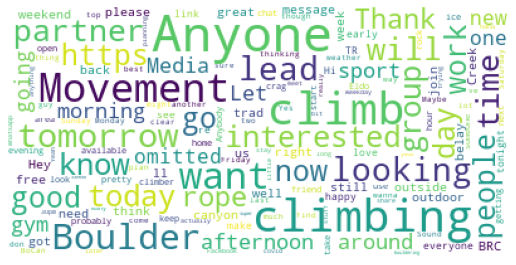

In [17]:
######### Add a wordcloud, summarize by most active people

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
to_add = ['https''.omitted']

for i in to_add:
    stopwords.add(i)

wordcloud = WordCloud(
                          collocations = False,
                          background_color='white',
                          stopwords=stopwords,
                          max_words=150,
                          max_font_size=40, 
                          random_state=42
                         ).generate(' '.join(wrds)) # can't pass a series, needs to be strings and function computes frequencies
print(wordcloud)
plt.figure(figsize=(9,20))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [18]:
########### tf idf for clustering ##########
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
tf_data = df['Message']
tf_idf_vectorizor = TfidfVectorizer(stop_words = stopwords,#tokenizer = tokenize_and_stem,
                             max_features = 5000)
tf_idf = tf_idf_vectorizor.fit_transform(tf_data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

KM = KMeans(4)
NNMF = NMF(4)

C:\Users\patno_000\Anaconda3.1\envs\tf_testing\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'https', 'isn', 'let', 'll', 'mustn', 'omitted', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [19]:
fittedKM = KM.fit(tf_idf_array)
fittedNNMF = NNMF.fit(tf_idf_array)
featuresNNMF = NNMF.transform(tf_idf_array)
print(featuresNNMF)

predictionKM = KM.predict(tf_idf_array)
predictionNNMF = NNMF.predict(tf_idf_array)

[[0.24607484 0.         0.         0.        ]
 [0.24607484 0.         0.         0.        ]
 [0.24607484 0.         0.         0.        ]
 ...
 [0.         0.29802466 0.         0.        ]
 [0.         0.29802466 0.         0.        ]
 [0.         0.         0.         0.        ]]


AttributeError: 'NMF' object has no attribute 'predict'

In [ ]:
plt.scatter(tf_idf_array[:, 2], tf_idf_array[:, 3],c=predictionKM ,s=50, cmap='viridis')

centers2 = fittedKM.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);


number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(tf_idf_array).score(tf_idf_array) for i in range(len(kmeans))]
score = [i*-1 for i in score]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, predictionKM, 20)




import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])


plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])


plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])

plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[3][:15])

    